In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
%matplotlib inline

In [2]:
def NGD(x,alpha,beta,K,g,phi):
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [3]:
def NGD_ff(x,alpha,beta,K,g,phi):
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j])) 
        dz=dt*(-beta*z[j]+g*x[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [4]:
# NGD orignal model with constant time memory
def NGD_const(x,alpha,tau_NGD,K):
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    for k in range(len(T)-1):
        if T[k]>tau_NGD:
            F=x[k-int(tau_NGD/dt)]
        else:
            F=0
        dy=dt*(-alpha*y[k]+K*(x[k]-F))
        y[k+1]=y[k]+dy
    return y,z

In [5]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [6]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i]=np.sum(MIsingle)
    return timeshift,MIvalue

In [7]:
def FFT_quick(data):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(x), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

(150, 152)

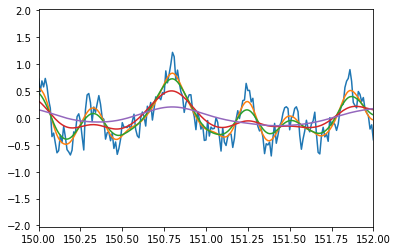

In [8]:
# generate OU
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=0.1
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering
fc=[5,3.5,2,1]
x_set=[L]
for ifc in range(len(fc)):
    b, a = signal.butter(2, 2*fc[ifc]*dt, btype='low', analog=False)
    Lf = signal.filtfilt(b, a, L)
    x_set.append(Lf)
    
for i in range(np.size(x_set,0)):
    plt.plot(T,x_set[i])
plt.xlim(150,152)

In [9]:
y_set=[[] for i in range(len(x_set))]
z_set=[[] for i in range(len(x_set))]
y_set_ff=[[] for i in range(len(x_set))]
z_set_ff=[[] for i in range(len(x_set))]
# alpha,beta,K,g=20,1,30,10
# FF prediction parameter 20,12,30,10
# damped oscillated parameter 8,1.4,37,10,1
# FF damped oscillated parameter 8,1.4,37,10,1

alpha,beta,K,g=6,2,18,10 # negative feedback parameter
alpha1,beta1,K1,g1=6,12,20,10 # negative feedforward parameter 6,5,20,10

for i in range(len(x_set)):
    y_set[i],z_set[i]=NGD(x_set[i],alpha,beta,K,g,1)
    y_set_ff[i],z_set_ff[i]=NGD_ff(x_set[i],alpha1,beta1,K1,g1,1)
#     y_set_ff[i],z_set_ff[i]=NGD_const(x_set[i],alpha,0.5,K,1)

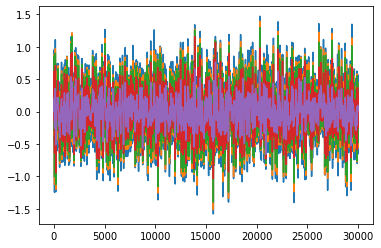

In [10]:
for i in range(len(x_set)):
    plt.plot(y_set_ff[i])

In [11]:
MI_set=[[] for i in range(len(x_set))]
MI_set_ff=[[] for i in range(len(x_set))]
for i in range(len(x_set)):
    timeshift,MI_set[i]=MI(EqualState(x_set[i],8),EqualState(y_set[i],8),dt,[-1,1])
    timeshift,MI_set_ff[i]=MI(EqualState(x_set[i],8),EqualState(y_set_ff[i],8),dt,[-1,1])

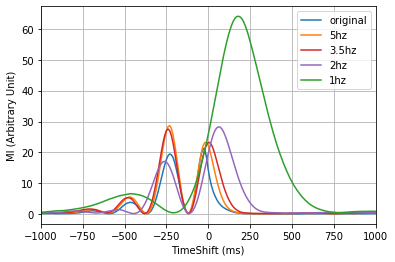

In [12]:
for i in range(np.size(x_set,0)):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    plt.plot(timeshift*1000,MI_set[i],color=colorlist[i])
    legend_list=[str(fc[j])+'hz' for j in range(len(fc))]
    legend_list.insert(0,'original')
#     plt.legend(('original','10hz','7hz','4hz','2hz'))
    plt.legend((legend_list))
    plt.xlabel('TimeShift (ms)')
    plt.ylabel('MI (Arbitrary Unit)')
plt.grid()
plt.xlim(-1000,1000)
plt.show()

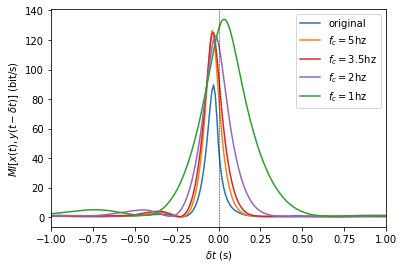

In [21]:
# feed forward
fFF,axFF=plt.subplots()
for i in range(np.size(x_set,0)):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    plt.plot(timeshift,MI_set_ff[i],color=colorlist[i])
    legend_list=[r'$f_c=$'+str(fc[j])+'hz' for j in range(len(fc))]
    legend_list.insert(0,'original')
#     plt.legend(('original','10hz','7hz','4hz','2hz'))
    plt.legend((legend_list))
    plt.xlabel(r'$\delta t$ (s)')
    plt.ylabel(r'$MI[x(t),y(t-\delta t)]$ (bit/s)')
# plt.grid()
plt.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
plt.xlim(-1,1)
plt.show()

In [22]:
fFF.savefig('F:/我的雲端硬碟/Master Thesis/Figures/appendix/FF model MI.pdf')